# Génération des réseaux de formes à partir des règles
- Gén-1 : génération des formes à partir de l'échantillon lexical
- Gén-2 : génération du réseau orienté à partir de Gén-1
- Filt-1 : extraction du sous-réseau symétrique
- Filt-2 : génération du réseau non-orienté correspondant à Filt-1
- Filt-3 : extraction des cliques maximales


## Importations
- codecs pour les encodages
- pandas et numpy pour les calculs sur tableaux
- matplotlib pour les graphiques
- itertools pour les itérateurs sophistiqués (paires sur liste, ...)

In [124]:
# -*- coding: utf8 -*-
import codecs
import features
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import pickle
import networkx as nx
#%pylab inline
#pd.options.display.mpl_style = 'default'
debug=False
from __future__ import print_function

In [125]:
import yaml

In [126]:
from ipywidgets import FloatProgress
from IPython.display import display, HTML

In [127]:
import datetime
def dateheure():
    return datetime.datetime.utcnow().strftime('%y%m%d%H%M')

In [128]:
saut="\n"

### Préparation des matrices de traits

In [129]:
features.add_config('bdlexique.ini')
fs=features.FeatureSystem('phonemes')

# Choix de l'échantillon et des règles
- *sampleFile* est le nom de l'échantillon de départ
- *analysisPrefix* est une partie du nom des règles

In [369]:
filePrefix="/Users/gilles/Box Sync/2015-Data/MGC-170330"
filePrefix="/Volumes/gilles/Transfert/Copies-iMac-GB/2015-Data/MGC-170430"
sampleNumber="19-20000Ko"
sampleType="S"
casesType="-Morphomes"
paperPrefix="-ISMo"
genFormeVotes=True
genCliques=True
listeFormesOutput=["FS","FP"]
genDigraphe=True
genGraphe=True
samplePrefix=filePrefix+"-%s-%s"%(sampleNumber,sampleType)+casesType
sampleFile=samplePrefix+"-paradigmes.csv"
analysisPrefix=samplePrefix
logfile_name=analysisPrefix+"-network.log"
logfile = codecs.open(logfile_name,mode='w',encoding="utf8")

### Préparation des cases du paradigme

# Préparation du calcul des analogies

### Calcul de la différence entre deux formes

In [370]:
def diff(mot1,mot2):
    result=[]
    diff1=""
    diff2=""
    same=""
    vide="."
    lmax=max(len(mot1),len(mot2))
    lmin=min(len(mot1),len(mot2))
    for index in range(lmax):
        if index < lmin:
            if mot1[index]!=mot2[index]:
                diff1+=mot1[index]
                diff2+=mot2[index]
                same+=vide
            else:
                same+=mot1[index]
                diff1+=vide
                diff2+=vide
        elif index < len(mot1):
            diff1+=mot1[index]
        elif index < len(mot2):
            diff2+=mot2[index]
    diff1=diff1.lstrip(".")
    diff2=diff2.lstrip(".")
#    return (same,diff1,diff2,diff1+"_"+diff2)
    return (diff1+"-"+diff2)

### Accumulation des paires appartenant à un patron

In [371]:
def rowDiff(row, patrons):
    result=diff(row[0],row[1])
    if not result in patrons:
        patrons[result]=(formesPatron(),formesPatron())
    patrons[result][0].ajouterFormes(row[0])
    patrons[result][1].ajouterFormes(row[1])
    return (result[0],result[1])

### Transformation d'un patron en RegExp

In [372]:
def patron2regexp(morceaux):
    result="^"
    for morceau in morceaux:
        if morceau=="*":
            result+="(.*)"
        elif len(morceau)>1:
            result+="(["+morceau+"])"
        else:
            result+=morceau
    result+="$"
    result=result.replace(")(","")
    return result

### Substitution de sortie 
???

In [373]:
def remplacementSortie(sortie):
    n=1
    nsortie=""
    for lettre in sortie:
        if lettre==".":
            nsortie+="\g<%d>"%n
            n+=1
        else:
            nsortie+=lettre
    return nsortie

# Classe pour la gestion des patrons, des classes et des transformations

In [374]:
class paireClasses:
    def __init__(self,case1,case2):
        self.case1=case1
        self.case2=case2
        self.nom=case1+"-"+case2
        self.classes1=classesPaire(case1,case2)
        self.classes2=classesPaire(case2,case1)

    def ajouterPatron(self,n,patron,motif):
        if n==1:
            self.classes1.ajouterPatron(patron,motif)
        elif n==2:
            self.classes2.ajouterPatron(patron,motif)
        else:
            print ("le numéro de forme n'est pas dans [1,2]",n,file=logfile)

    def ajouterPaire(self,forme1,forme2):
        self.classes1.ajouterPaire(forme1,forme2)
        self.classes2.ajouterPaire(forme2,forme1)
        
    def calculerClasses(self):
        return(self.classes1,self.classes2)

    
class classesPaire:
    '''
    Gestion des patrons, des classes et des transformations
    
    ajouterPatron : ajoute un patron et son motif associé (MGL)
    ajouterPaire : ajoute une paire de formes, calcule la classe de la forme1 et la règle sélectionnée
    sortirForme : cacule les formes de sortie correspondant à la forme1 avec leurs coefficients respectifs
    '''
    def __init__(self,case1,case2):
        self.case1=case1
        self.case2=case2
        self.nom=case1+"-"+case2
        self.classe={}
        self.nbClasse={}
        self.patrons={}
        self.entree={}
        self.sortie={}
    
    def ajouterPatron(self,patron,motif):
        self.patrons[patron]=motif
        (entree,sortie)=patron.split("-")
        self.entree[patron]=entree.replace(u".",u"(.)")
        self.sortie[patron]=remplacementSortie(sortie)
    
    def ajouterPaire(self,forme1,forme2):
        '''
        on calcule la classe de la paire idClasseForme et la règle sélectionnée
        on incrémente le compteur de la classe et celui de la règle sélectionnée à l'intérieur de la classe
        '''
        classeForme=[]
        regleForme=""
        for patron in self.patrons:
            if re.match(self.patrons[patron],forme1):
                classeForme.append(patron)
                '''
                le +"$" permet de forcer l'alignement à droite pour les transformations suffixales
                '''
                if forme2==re.sub(self.entree[patron]+"$",self.sortie[patron],forme1):
                    regleForme=patron
        idClasseForme=", ".join(classeForme)
        if not idClasseForme in self.classe:
            self.classe[idClasseForme]={}
            self.nbClasse[idClasseForme]=0
        if not regleForme in self.classe[idClasseForme]:
            self.classe[idClasseForme][regleForme]=0
        self.nbClasse[idClasseForme]+=1
        self.classe[idClasseForme][regleForme]+=1

    def sortirForme(self,forme):
        classeForme=[]
        sortieForme={}
        for patron in self.patrons:
            if re.match(self.patrons[patron],forme):
                classeForme.append(patron)
        if classeForme:
            idClasseForme=", ".join(classeForme)
            if idClasseForme in self.nbClasse:
                nTotal=self.nbClasse[idClasseForme]
                for patron in self.classe[idClasseForme]:
                    sortie=re.sub(self.entree[patron]+"$",self.sortie[patron],forme)
                    sortieForme[sortie]=float(self.classe[idClasseForme][patron])/nTotal
            else:
                if debug:
                    print (forme, file=logfile)
                    print ("pas de classe",idClasseForme, file=logfile)
                    print ("%.2f par forme de sortie" % (float(1)/len(classeForme)), file=logfile)
                nTotal=len(classeForme)
                for patron in classeForme:
                    sortie=re.sub(self.entree[patron]+"$",self.sortie[patron],forme)
                    sortieForme[sortie]=float(1)/nTotal
        else:
            print (forme, file=logfile) 
            print ("pas de patron", file=logfile)
        return sortieForme
        

## Appliquer la formule de calcul des différences entre chaines à chaque ligne

>si il y a au moins une ligne

>>on applique la différence à la ligne

>>on calcule les deux patrons par suppression des points initiaux

>>on renvoie le groupement par patrons (1&2)

>sinon

>>on renvoie le paradigme vide d'origine

In [375]:
def rapports(paradigme):
    if len(paradigme.columns.values.tolist())==2:
        (case1,lexeme)= paradigme.columns.values.tolist()
        case2=case1
    else:
        (case1,case2,lexeme)= paradigme.columns.values.tolist()
    patrons=pairePatrons(case1,case2)
    classes=paireClasses(case1,case2)
    if len(paradigme)>0:
        paradigme.apply(lambda x: patrons.ajouterFormes(x[case1],x[case2],diff(x[case1],x[case2])), axis=1)
        (regles1,regles2)=patrons.calculerGM()
        for regle in regles1:
            classes.ajouterPatron(1,regle,regles1[regle])
        for regle in regles2:
            classes.ajouterPatron(2,regle,regles2[regle])
        paradigme.apply(lambda x: classes.ajouterPaire(x[case1],x[case2]), axis=1)
    (classes1,classes2)=classes.calculerClasses()
    return (classes1,classes2)

### Dédoubler les lignes avec des surabondances dans *colonne*
>identifier une ligne avec surabondance

>>ajouter les lignes correspondant à chaque valeur

>>ajouter le numéro de la ligne initiale dans les lignes à supprimer

>supprimer les lignes avec surabondance

NB : il faut préparer le tableau pour avoir une indexation qui permette l'ajout des valeurs individuelles et la suppression des lignes de surabondances

In [376]:
def splitCellMates(df,colonne):
    '''
    Calcul d'une dataframe sans surabondance par dédoublement des valeurs
    '''
    test=df.reset_index()
    del test["index"]
    splitIndexes=[]
    for index,ligne in test.iterrows():
        if "," in ligne[colonne]:
            valeurs=set(ligne[colonne].split(","))
            nouvelleLigne=ligne
            for valeur in valeurs:
                nouvelleLigne[colonne]=valeur
                test=test.append(nouvelleLigne,ignore_index=True)
            splitIndexes.append(index)
    if splitIndexes:
        test=test.drop(test.index[splitIndexes])
    return test


In [377]:
paradigmes=pd.read_csv(sampleFile,sep=";",encoding="utf8")
del paradigmes[u"Unnamed: 0"]
paradigmes=paradigmes.dropna(axis=1,how='all')

In [378]:
phonologicalMap=sampleType
if debug: print(phonologicalMap)
neutralisationsNORD=(u"6û",u"9ê")
neutralisationsSUD=(u"e2o",u"E9O")
if phonologicalMap=="N":
    neutralisations=neutralisationsNORD
elif phonologicalMap=="S":
    neutralisations=neutralisationsSUD
else:
    neutralisations=(u"",u"")
    phonologicalMap=("X")
bdlexiqueIn = unicode(u"èò"+neutralisations[0])
bdlexiqueNum = [ord(char) for char in bdlexiqueIn]
neutreOut = unicode(u"EO"+neutralisations[1])
neutralise = dict(zip(bdlexiqueNum, neutreOut))

In [379]:
def recoder(chaine,table=neutralise):
    if type(chaine)==str:
        temp=unicode(chaine.decode('utf8')).translate(table)
        result=temp.encode('utf8')
    elif type(chaine)==unicode:
        result=chaine.translate(table)
    else:
        result=chaine
    return result

In [380]:
goldCases=paradigmes.columns.tolist()
goldCases.remove("lexeme")
#goldCases

- sampleCases pour la liste des cases effectivement représentées dans le corpus de départ 

In [381]:
sampleCases=paradigmes.columns.values.tolist()
sampleCases.remove(u"lexeme")
#sampleCases

In [382]:
paradigmes.stack().value_counts(dropna=True).sum()

59969

In [383]:
with open(analysisPrefix+'-Regles.pkl', 'rb') as input:
    resultatsLecture = pickle.load(input)

### Comparer les cases analysées avec l'ensemble de toutes les cases

In [384]:
analyseCases=list(set([case for (case,autre) in resultatsLecture.keys()]))
if sorted(analyseCases)!=sorted(goldCases):
    print ("Attention l'analyse ne comprend pas toutes les cases")
    print (sorted(analyseCases))
    print (sorted(goldCases))

In [385]:
class paradigmeDistribution:
    '''
    Gestion des distributions dans les cases du paradigme
    '''

    def __init__(self,lexeme):
        self.lexeme=lexeme
        self.formes={i:{} for i in analyseCases}

    def ajouterFormes(self,case,formes,coef=1.0):
        for forme in formes:
            if not forme in self.formes[case]:
                self.formes[case][forme]=0
            self.formes[case][forme]+=formes[forme]*coef
            
    def normaliserDistributions(self,caseListe=analyseCases):
        normalesDistributions={i:{} for i in caseListe}
        for case in caseListe:
            total=0
            for element in self.formes[case]:
                total+=self.formes[case][element]
            for element in self.formes[case]:
                normalesDistributions[case][element]=float(self.formes[case][element])/total
        return normalesDistributions
        

In [386]:
def generateForms(lexeme):
    candidats=paradigmeDistribution(lexeme)
    casesSamples=paradigmes[paradigmes["lexeme"]==lexeme].columns[paradigmes[paradigmes["lexeme"]==lexeme].notnull().iloc[0]].tolist()
    casesSamples.remove("lexeme")
    for caseDepart in casesSamples:
        formeDepart=paradigmes[paradigmes["lexeme"]==lexeme][caseDepart].iloc[0]
        if debug: print (caseDepart,formeDepart, file=logfile)
#        if formeDepart!="nan":
        for case in analyseCases:
            if debug: print (case, file=logfile)
            if not isinstance(resultatsLecture[(caseDepart, case)],str):
                if "," in formeDepart:
                    formesDepart=formeDepart.split(",")
                    coef=1.0/len(formesDepart)
                    for element in formesDepart:
                        candidats.ajouterFormes(case,resultatsLecture[(caseDepart, case)].sortirForme(element),coef)
                else:
                    candidats.ajouterFormes(case,resultatsLecture[(caseDepart, case)].sortirForme(formeDepart))
            else: 
                if debug: print ("str", resultatsLecture[(caseDepart, case)], file=logfile)
    return candidats

In [387]:
def ajouterPoint(lexeme,forme,case,digraphe,graphe):
    pointName="%s-%s-%s"%(lexeme,forme,case)
#    if not pointName in digraphe.nodes():
    tam=case[:2]
    if tam=="in": tam="inf"
    digraphe.add_node(pointName, tam='"%s"'%tam)
    graphe.add_node(pointName, tam='"%s"'%tam)
    return pointName

def ajouterFleche(pointDepart,pointSortie,coef,digraphe,graphe):
    digraphe.add_edge(pointDepart,pointSortie,weight=float(coef))
    if digraphe.has_edge(pointSortie,pointDepart):
        coefGraphe=float(digraphe.edge[pointSortie][pointDepart]["weight"]+coef)/2
        graphe.add_edge(pointDepart,pointSortie,weight=coefGraphe)

In [388]:
def generateParadigms(generation1,genDigraphe=True):
    lexeme=generation1.lexeme
    distributionInitiale=generation1.normaliserDistributions()
    candidats=paradigmeDistribution(lexeme)
    digraphe=nx.DiGraph()
    graphe=nx.Graph()    
    for caseDepart in analyseCases:
        for formeDepart in distributionInitiale[caseDepart]:
            if formeDepart:
                pointDepart=ajouterPoint(lexeme,formeDepart,caseDepart,digraphe,graphe)
                coefDepart=distributionInitiale[caseDepart][formeDepart]
                if debug: print (caseDepart,formeDepart, file=logfile)
                for caseSortie in analyseCases:
                    distributionSortieBrute=resultatsLecture[(caseDepart, caseSortie)].sortirForme(formeDepart)
                    if distributionSortieBrute:
                        if not genDigraphe:
#                            print ("brute",distributionSortieBrute)
                            distributionSortie={f:distributionSortieBrute[f] for f in distributionSortieBrute if f in distributionInitiale[caseSortie]}
                        else:
                            distributionSortie=distributionSortieBrute
#                        print ("filtre",distributionSortie)
#                        print (distributionInitiale[caseSortie])
                        if debug: print (caseSortie,distributionSortie,distributionInitiale[caseDepart], file=logfile)
                        candidats.ajouterFormes(caseSortie,distributionSortie,distributionInitiale[caseDepart][formeDepart])
                        for formeSortie in distributionSortie:
                            pointSortie=ajouterPoint(lexeme,formeSortie,caseSortie,digraphe,graphe)
                            coefSortie=distributionSortie[formeSortie]
                            ajouterFleche(pointDepart,pointSortie,float(coefDepart*coefSortie),digraphe,graphe)
    return (candidats,digraphe,graphe)

In [389]:
def generate(lexeme,genDigraphe=True):
#    print (lexeme,end=", ")
    generation1=generateForms(lexeme)
#    print ("génération 2",end=", ")
    (generation2,lexDigraphe,lexGraphe)=generateParadigms(generation1,genDigraphe)
    lexCliques=list(nx.algorithms.clique.find_cliques(lexGraphe))
#    print (lexCliques)
#    print ("génération 3")
    return (generation2,lexDigraphe,lexGraphe,lexCliques)

In [390]:
len(paradigmes.dropna(thresh=1)["lexeme"])

5312

In [391]:
#paradigmes
#analyseCases
lexeme=u"découper"
paradigmes[paradigmes["lexeme"]==lexeme].columns[paradigmes[paradigmes["lexeme"]==lexeme].notnull().iloc[0]].tolist()

[u'lexeme',
 u'ai1S',
 u'ai2S',
 u'ai3P',
 u'fi1P',
 u'fi1S',
 u'fi2P',
 u'fi2S',
 u'ii1P',
 u'ii1S',
 u'inf',
 u'pI1P',
 u'pI2P',
 u'pI2S',
 u'pP',
 u'pi1P',
 u'pi1S',
 u'pi2P',
 u'pi2S',
 u'pi3P',
 u'pi3S',
 u'ppFP',
 u'ppMP']

In [392]:
paradigmes.dropna(thresh=1).count().sum()-paradigmes.dropna(thresh=1)["lexeme"].count()

54657

#### Calculer le score de la clique

In [393]:
def cliqueScore(clique,graph):
    score=0
    if len(clique)>1:
        for (depart,arrivee) in it.combinations_with_replacement(clique,2):
            score+=graph[depart][arrivee]["weight"]
    return score

In [394]:
def splitArrivee(arrivee):
    arriveeMorceaux=arrivee.split("-")
    lexeme="-".join(arriveeMorceaux[:-2])
    formeArrivee=arriveeMorceaux[-2]
    caseArrivee=arriveeMorceaux[-1]
    return (lexeme,formeArrivee,caseArrivee)
    
# trouver tous les liens vers FS-* et FP-*
# regrouper par forme 
# calculer les proportions
# renvoyer les proportions par forme
# avec le nombre de forme à l'appui
def formeScore(forme,graph):
    scores={}
    scoresNormes={}
    for depart in graph.edge:
        for arrivee in graph.edge[depart]:
            (lexeme, formeArrivee, caseArrivee)=splitArrivee(arrivee)
            if caseArrivee==forme:
#                print (depart, formeArrivee, graph.edge[depart][arrivee])
                if not formeArrivee in scores:
                    scores[formeArrivee]=0
                scores[formeArrivee]+=graph.edge[depart][arrivee]["weight"]
    totalArrivee=0
    for formeArrivee in scores:
        totalArrivee+=scores[formeArrivee]
    for formeArrivee in scores:
        scoresNormes[formeArrivee]=scores[formeArrivee]/totalArrivee
    return (scores,scoresNormes)
        

## Génération des formes

In [409]:
#%%time
debug=False
listeTest=paradigmes.dropna(thresh=1)["lexeme"].values.tolist()
listeTest=[u"abouler", u"abroger", u"admonester", u"aguicher", u"ajourer", u"ankyloser", u"antidater", 
           u"architecturer", u"argenter", u"arraisonner", u"asphalter", u"assermenter", u"autopsier", 
           u"banquer", u"biberonner", u"biner", u"bossuer", u"botteler", u"boucaner", u"bourlinguer", 
           u"braiser", u"brasiller", u"brigander", u"brimbaler", u"brinquebaler", u"brocarder", u"buriner", 
           u"bétonner", u"bêtifier", u"cadencer", u"canoniser", u"canonner", u"canoter", u"caparaçonner", 
           u"capitaliser", u"capitonner", u"caricaturer", u"carminer", u"carreler", u"cauchemarder", 
           u"cautériser", u"chaperonner", u"chapitrer", u"charpenter", u"chatoyer", u"chauler", 
           u"circonvenir", u"clamser", u"clapper", u"classifier", u"colleter", u"congestionner", 
           u"criailler", u"crotter", u"croustiller", u"crépir", u"cuivrer", u"daller", u"dessiller", 
           u"discutailler", u"débaptiser", u"déblatérer", u"déboussoler", u"débouter", u"débraguetter", 
           u"débroussailler", u"décalotter", u"décapuchonner", u"déclasser", u"déclouer", u"dédire", 
           u"défalquer", u"défavoriser", u"défraîchir", u"défroquer", u"démunir", u"démâter", u"déniaiser", 
           u"dépeigner", u"déplisser", u"dépolir", u"déposséder", u"dépraver", u"dépressuriser", u"désappointer", 
           u"désavantager", u"désemparer", u"désenfler", u"désengager", u"désennuyer", u"emberlificoter", 
           u"empailler", u"emperler", u"empierrer", u"emplumer", u"encarter", u"enchérir", u"encoder", 
           u"encoller", u"endiabler", u"endimancher", u"endoctriner", u"engouer", u"engrener", u"enneiger", 
           u"enrubanner", u"ensoleiller", u"entr'apercevoir", u"entre-déchirer", u"entre-dévorer", 
           u"entre-regarder", u"essaimer", u"estampiller", u"estoquer", u"expectorer", u"fabuler", u"fanatiser", 
           u"fauter", u"fermenter", u"festonner", u"flemmarder", u"fourgonner", u"fragiliser", u"fricasser", 
           u"frigorifier", u"fronder", u"galber", u"galonner", u"gauchir", u"gaufrer", u"givrer", u"godiller", 
           u"grasseyer", u"grener", u"grillager", u"gréer", u"grêler", u"gîter", u"habiliter", u"hospitaliser", 
           u"hâler", u"ignifuger", u"imager", u"initialiser", u"interloquer", u"invalider", u"jargonner", 
           u"jasper", u"javelliser", u"juter", u"lanterner", u"ligner", u"limoger", u"lister", u"magnétiser", 
           u"mailler", u"majorer", u"manucurer", u"manufacturer", u"marginaliser", u"marqueter", u"matelasser", 
           u"materner", u"mazer", u"meuler", u"mitiger", u"morfaler", u"mystifier", u"métisser", u"métrer", 
           u"officialiser", u"orthographier", u"ouater", u"oxyder", u"pager", u"palmer", u"panner", u"passiver", 
           u"pelleter", u"piqueter", u"plastiquer", u"polycopier", u"ponctionner", u"ponter", u"portraiturer", 
           u"préfacer", u"présupposer", u"pâturer", u"pérégriner", u"raciner", u"ragoter", u"randonner", 
           u"rapetasser", u"rapiécer", u"ratiboiser", u"rationaliser", u"rebaisser", u"recasser", u"recrépir", 
           u"rediffuser", u"regarnir", u"reloger", u"remailler", u"remarcher", u"remblayer", u"remplier", 
           u"renfler", u"rependre", u"ressemeler", u"retranscrire", u"retremper", u"retéléphoner", u"revaloir", 
           u"revancher", u"revivifier", u"ripailler", u"ripoliner", u"réadapter", u"réembaucher", u"réengager", 
           u"réfracter", u"réfrigérer", u"réguler", u"réhabituer", u"réinviter", u"répertorier", u"rééduquer", 
           u"rééquilibrer", u"sabouler", u"saccader", u"salarier", u"saloper", u"satiner", u"schématiser", 
           u"sevrer", u"singulariser", u"socialiser", u"sonoriser", u"souquer", u"sourciller", u"spiritualiser", 
           u"surajouter", u"surfaire", u"surgeler", u"suturer", u"talquer", u"tarer", u"tournebouler", u"transmuer", 
           u"triquer", u"truster", u"tuméfier", u"valdinguer", u"vaticiner", u"veiner", u"verbaliser", u"verdoyer", 
           u"vilipender", u"vinaigrer", u"viner", u"violacer", u"vitupérer", u"zipper", u"zozoter", u"écrouer", 
           u"édulcorer", u"émacier", u"épeurer", u"épiloguer", u"équarrir", u"érotiser", u"étriquer", u"étrécir", 
           u"évangéliser"]
listeTest=[u"corriger",u"résulter",u"émerger",u"injecter","concevoir","collaborer",u"coopérer",u"méditer"]
listeTest=[u"crépir"]
nbVerbes=len(listeTest)
print (nbVerbes)
globDigraphe=nx.DiGraph()
globGraphe=nx.Graph()
cliques=[]
cliquesScores={}
cliquesListes={}
numClique=0
formesScores={}
formesScoresNormes={}
progressBar = FloatProgress(min=0, max=nbVerbes)
display(progressBar)
for i,element in enumerate(listeTest):
    cliquesScores[element]={}
    cliquesListes[element]={}
#    if (i%100)==0: print (i, dateheure()[-4:], int(100*float(i)/nbVerbes), end=", ")
    progressBar.value=i
    #print (element)
    result=generate(element,genDigraphe)
    (generation,lexDigraphe,lexGraphe,lexCliques)= result
#    print (generation,lexDigraphe,lexGraphe,lexCliques)
    if genFormeVotes:
        formesScores[element]={}
        formesScoresNormes[element]={}
        for formeOutput in listeFormesOutput:
            (formesScores[element][formeOutput],formesScoresNormes[element][formeOutput])=formeScore(formeOutput,lexDigraphe)
    if genDigraphe:
        globDigraphe=nx.union(globDigraphe,lexDigraphe)
    if genGraphe:
        globGraphe=nx.union(globGraphe,lexGraphe)
    cliques.extend(lexCliques)
    for clique in lexCliques:
        cliquesScores[element][numClique]=cliqueScore(clique,lexGraphe)
        cliquesListes[element][numClique]=clique
        numClique+=1

1


In [410]:
globDigraphe.edges()

[(u'cr\xe9pir-krEpiz-pi3P', u'cr\xe9pir-krEpizE-ai1S'),
 (u'cr\xe9pir-krEpiz-pi3P', u'cr\xe9pir-krEpizE-pI2P'),
 (u'cr\xe9pir-krEpiz-pi3P', u'cr\xe9pir-krEpiz-pi3P'),
 (u'cr\xe9pir-krEpiz-pi3P', u'cr\xe9pir-krEpizam-ai1P'),
 (u'cr\xe9pir-krEpiz-pi3P', u'cr\xe9pir-krEpiz-pi1S'),
 (u'cr\xe9pir-krEpiz-pi3P', u'cr\xe9pir-krEpiz\xe2-pP'),
 (u'cr\xe9pir-krEpiz-pi3P', u'cr\xe9pir-krEpizasj\xf4-is1P'),
 (u'cr\xe9pir-krEpiz-pi3P', u'cr\xe9pir-krEpiz-pi2S'),
 (u'cr\xe9pir-krEpiz-pi3P', u'cr\xe9pir-krEpizj\xf4-ii1P'),
 (u'cr\xe9pir-krEpiz-pi3P', u'cr\xe9pir-krEpiz6rjE-pc2P'),
 (u'cr\xe9pir-krEpiz-pi3P', u'cr\xe9pir-krEpiz-pi3S'),
 (u'cr\xe9pir-krEpiz-pi3P', u'cr\xe9pir-krEpirj\xf4-pc1P'),
 (u'cr\xe9pir-krEpiz-pi3P', u'cr\xe9pir-krEpir-inf'),
 (u'cr\xe9pir-krEpiz-pi3P', u'cr\xe9pir-krEpizi-ppMP'),
 (u'cr\xe9pir-krEpiz-pi3P', u'cr\xe9pir-krEpizjE-ii2P'),
 (u'cr\xe9pir-krEpiz-pi3P', u'cr\xe9pir-krEpiz\xf4-pi1P'),
 (u'cr\xe9pir-krEpiz-pi3P', u'cr\xe9pir-krEpiz-pI2S'),
 (u'cr\xe9pir-krEpiz-pi3P', u'cr

In [411]:
if genFormeVotes:
    fScores=(formesScores,formesScoresNormes)
    with open(analysisPrefix+paperPrefix+'-Scores.pkl', 'wb') as output:
        pickle.dump(fScores, output, pickle.HIGHEST_PROTOCOL)

In [412]:
%%time
versionStamp=dateheure()
if genDigraphe and len(listeTest)==1: 
    nx.readwrite.write_gexf(globDigraphe,analysisPrefix+paperPrefix+u"-digraphe-%s.gexf"%versionStamp)
if genGraphe and len(listeTest)==1:
    nx.readwrite.write_gexf(globGraphe,analysisPrefix+paperPrefix+u"-graphe-%s.gexf"%versionStamp)

CPU times: user 166 ms, sys: 7.75 ms, total: 174 ms
Wall time: 1.6 s


In [413]:
print (len(cliques))

338


In [414]:
if genCliques:
    infoCliques={"cliques":cliques, "cliquesScores":cliquesScores, "cliquesListes":cliquesListes}
    with open(analysisPrefix+paperPrefix+'-Network.pkl', 'wb') as output:
        pickle.dump(infoCliques, output, pickle.HIGHEST_PROTOCOL)

In [415]:
lexemeMaxCliques={}
for lexeme in cliquesListes:
    maxLen=max([len(c) for c in cliquesListes[lexeme].values()])
    maxCliques=[c for c in cliquesListes[lexeme].values() if len(c)==maxLen]
    lexemeMaxCliques[lexeme]=(maxLen,maxCliques)

In [416]:
def dictCliqueForms(clique):
    result={}
    for element in clique:
        lexeme,forme,case=splitArrivee(element)
        result[case]=forme
    return result

def dictPdRowForms(row):
    result={}
    for case in sampleCases:
        print (case,row[case].values[0])
    return result

def tableZero(case):
    if case in sampleCases:
        return u"Ø"
    else:
        return u"="

def makeTable(dictForms,title=""):
    tabular=[]
    labelTenseCode={"pi":"Present","ii":"Imperfective","ai":"Simple Past","fi":"Future",
                    "ps":"Subjunctive Pres.","is":"Subjunctive Imp.","pc":"Conditional","pI":"Imperative",
                    "inf":"Infinitive",
                    "ppMS":"Past Part. MS","ppMP":"Past Part. MP",
                    "ppFS":"Past Part. FS","ppMP":"Past Part. FP"
                   }
    def makeLine6(tenseCode):
        line=[]
        line.append(r"<th>%s</th>"%labelTenseCode[tenseCode])
        for person in [per+nb for nb in ["S","P"] for per in ["1","2","3"]]:
            case=tenseCode+person
            if (case in dictForms) and (not (type(dictForms[case]) == float and np.isnan(dictForms[case]))):
                line.append(r"<td>%s</td>"%(dictForms[case]))
            else:
                line.append(r"<td>%s</td>"%(tableZero(case)))
        return r"<tr>"+r"".join(line)+r"</tr>"

    def makeLine3(tenseCode):
        line=[]
        line.append(r"<th>%s</th>"%labelTenseCode[tenseCode])
        for person in [per+nb for nb in ["S","P"] for per in ["1","2","3"]]:
            if person in ["2S","1P","2P"]:
                case=tenseCode+person
                if case in dictForms and (not (type(dictForms[case]) == float and np.isnan(dictForms[case]))):
                    line.append(r"<td>%s</td>"%(dictForms[case]))
                else:
                    line.append(r"<td>%s</td>"%(tableZero(case)))
            else:
                line.append(r"<td>%s</td>"%(u"---"))
        return r"<tr>"+r"".join(line)+r"</tr>"
    
    def makeLineNF():
        line=[]
        line.append(r"<th>%s</th>"%"NF")
        for case in ["inf","pP","ppMS","ppMP","ppFS","ppFP"]:
            if case in dictForms and (not (type(dictForms[case]) == float and np.isnan(dictForms[case]))):
                line.append(r"<td>%s</td>"%(dictForms[case]))
            else:
                line.append(r"<td>%s</td>"%(tableZero(case)))
        return r"<tr>"+r"".join(line)+r"</tr>"
    
        
    top=[
        r"<table>",
        r"<caption style='caption-side:bottom;text-align:center'>",
        "Verbe : %s"%title,
        r"</caption>",
#        r"<tr><th/><th>1S</th><th>2S</th><th>3S</th><th>1P</th><th>2P</th><th>3P</th></tr>"
        r"<tr><th/><th>1SG</th><th>2SG</th><th>3SG</th><th>1PL</th><th>2PL</th><th>3PL</th></tr>"
        ]
    bottom=[
        r"</table>"
        ]
    tabular.append("\n".join(top))
    for tenseCode in ["pi","ii","fi","pc", "ps","ai", "is"]:
        tabular.append(makeLine6(tenseCode))
    tabular.append(makeLine3("pI"))
    tabular.append(makeLineNF())
    tabular.append("\n".join(bottom))
    return "\n".join(tabular)    

def diffParadigme(lexeme):
    outLen=lexemeMaxCliques[lexeme][0]
    inLen=paradigmes[paradigmes["lexeme"]==lexeme].notnull().sum(axis=1).values[0]-1
    if outLen>inLen:
        print (lexemeMaxCliques[lexeme][1])
        print (paradigmes[paradigmes["lexeme"]=="grandir"].values)
    return outLen-inLen
    

In [453]:
for lexeme in lexemeMaxCliques:
    for clique in lexemeMaxCliques[lexeme][1]:
        display(HTML(makeTable(dictCliqueForms(clique),title=lexeme)))
lexeme=u"crépir"

In [418]:
print (paradigmes[paradigmes["lexeme"]==lexeme].to_latex(na_rep=""))

\begin{tabular}{lllllllllllllllllllllllllllllllllll}
\toprule
{} &  lexeme & ai1P & ai1S & ai2P & ai2S & ai3P & fi1P & fi1S & fi2P & fi2S & ii1P & ii1S & ii2P &     inf & is1P & is1S & is2P & pI1P & pI2P & pI2S & pP & pc1P & pc2P & pi1P & pi1S &     pi2P & pi2S & pi3P & pi3S &   ppFP &   ppMP & ps1P & ps1S & ps2P \\
\midrule
1166 &  crépir &      &      &      &      &      &      &      &      &      &      &      &      &  krEpir &      &      &      &      &      &      &    &      &      &      &      &  krEpisE &      &      &      &  krEpi &  krEpi &      &      &      \\
\bottomrule
\end{tabular}



In [419]:
%matplotlib inline

104


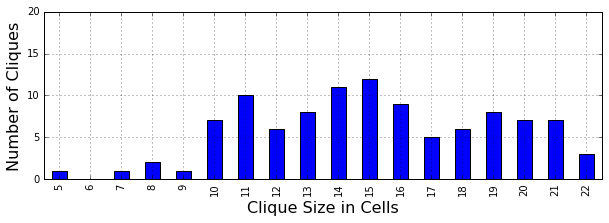

In [449]:
cliquesBrutes={n+1:0 for n in range(25)}
for l in cliquesListes[u"crépir"].values():
    longueur=len(l)
    if longueur>1:
        if not longueur in cliquesBrutes:
            cliquesBrutes[longueur]=0
        cliquesBrutes[longueur]+=1
print (sum([v for k,v in cliquesBrutes.iteritems()]))
ax=pd.DataFrame.from_dict(cliquesBrutes,orient="index").plot(kind="bar",legend=False,grid=True,figsize=(10,3))
ax.set(xlim=(3.5,21.5),ylim=(0,20))
ax.set_xlabel("Clique Size in Cells",fontsize=16)
ax.set_ylabel("Number of Cliques",fontsize=16)

In [430]:
dictParadigmes=paradigmes.set_index("lexeme").to_dict(orient="index")

In [431]:
cliquesFideles={}
fidelites=[v+"-"+k for k,v in dictParadigmes[u"crépir"].iteritems() if isinstance(v,unicode)]
for l in cliquesListes[u"crépir"].values():
    longueur=len(l)
    if longueur>1:
        fidele=True
        for fidelite in fidelites:
            lFidele=False
            for element in l:
                if fidelite in element:
                    lFidele=True
            if not lFidele:
                fidele=False
                break
        if fidele:
            if not longueur in cliquesFideles:
                cliquesFideles[longueur]=[]
            cliquesFideles[longueur].append(l)
[(k,len(v)) for k,v in cliquesFideles.iteritems()]

[(14, 1), (15, 1), (16, 1), (17, 1), (19, 1), (20, 1)]

In [457]:
cliquesFideles[20]

[[u'cr\xe9pir-krEpi-ai2S',
  u'cr\xe9pir-krEpir-ai3P',
  u'cr\xe9pir-krEpir-inf',
  u'cr\xe9pir-krEpisE-pi2P',
  u'cr\xe9pir-krEpisE-ii1S',
  u'cr\xe9pir-krEpi-ppMP',
  u'cr\xe9pir-krEpisE-pI2P',
  u'cr\xe9pir-krEpi-ppFP',
  u'cr\xe9pir-krEpis\xf4-pI1P',
  u'cr\xe9pir-krEpir\xf4-fi1P',
  u'cr\xe9pir-krEpis\xe2-pP',
  u'cr\xe9pir-krEpi-pi3S',
  u'cr\xe9pir-krEpi-pi1S',
  u'cr\xe9pir-krEpi-pi2S',
  u'cr\xe9pir-krEpi-pI2S',
  u'cr\xe9pir-krEpis\xf4-pi1P',
  u'cr\xe9pir-krEpisj\xf4-ii1P',
  u'cr\xe9pir-krEpisjE-ii2P',
  u'cr\xe9pir-krEpis-pi3P',
  u'cr\xe9pir-krEpis-ps1S']]

In [434]:
HTML(makeTable(dictParadigmes[lexeme],title=lexeme))

33 [u'ai1P', u'ai1S', u'ai2P', u'ai2S', u'ai3P', u'fi1P', u'fi1S', u'fi2P', u'fi2S', u'ii1P', u'ii1S', u'ii2P', u'inf', u'is1P', u'is1S', u'is2P', u'pI1P', u'pI2P', u'pI2S', u'pP', u'pc1P', u'pc2P', u'pi1P', u'pi1S', u'pi2P', u'pi2S', u'pi3P', u'pi3S', u'ppFP', u'ppMP', u'ps1P', u'ps1S', u'ps2P'] 5312


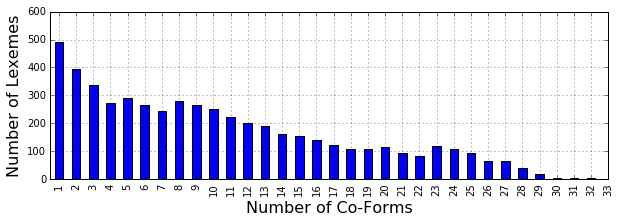

In [437]:
print (len(sampleCases),sampleCases,paradigmes["lexeme"].count())
nbCoformes=paradigmes.notnull().sum(axis=1)-1
distNbCoformes=nbCoformes.groupby(by=nbCoformes).count()
ax=distNbCoformes.plot(kind="bar",legend=False,grid=True,figsize=(10,3))
ax.set(xlim=(-0.5,32),ylim=(0,600))
ax.set_xlabel("Number of Co-Forms",fontsize=16)
ax.set_ylabel("Number of Lexemes",fontsize=16)

In [408]:
print ('", u"'.join(paradigmes[(paradigmes.notnull().sum(axis=1))==5]["lexeme"].tolist()))

abouler", u"abroger", u"admonester", u"aguicher", u"ajourer", u"ankyloser", u"antidater", u"architecturer", u"argenter", u"arraisonner", u"asphalter", u"assermenter", u"autopsier", u"banquer", u"biberonner", u"biner", u"bossuer", u"botteler", u"boucaner", u"bourlinguer", u"braiser", u"brasiller", u"brigander", u"brimbaler", u"brinquebaler", u"brocarder", u"buriner", u"bétonner", u"bêtifier", u"cadencer", u"canoniser", u"canonner", u"canoter", u"caparaçonner", u"capitaliser", u"capitonner", u"caricaturer", u"carminer", u"carreler", u"cauchemarder", u"cautériser", u"chaperonner", u"chapitrer", u"charpenter", u"chatoyer", u"chauler", u"circonvenir", u"clamser", u"clapper", u"classifier", u"colleter", u"congestionner", u"criailler", u"crotter", u"croustiller", u"crépir", u"cuivrer", u"daller", u"dessiller", u"discutailler", u"débaptiser", u"déblatérer", u"déboussoler", u"débouter", u"débraguetter", u"débroussailler", u"décalotter", u"décapuchonner", u"déclasser", u"déclouer", u"dédire", u"

In [357]:
tirage='/Volumes/gilles/Transfert/Copies-iMac-GB/2015-Data/MGC-170430-19-20000Ko-Tirage-S-170503-1927-Morphomes.pkl'
with open(tirage, 'rb') as input:
    sampleTirage = pickle.load(input)

In [458]:
sampleTirage[(sampleTirage["lexeme"]==u"être") & (sampleTirage["tir1"]!=0)]

,lexeme,phono,case,morphome,freq,tir1
54681,être,E,pi2S,pi2S,2.105690e+11,134446
54682,être,E,pi3S,pi3S,2.574944e+12,1648563
54683,être,Et,pi2P,pi2P,5.992100e+10,38574
54684,être,EtE,ii1S,ii1S/ii2S/ii3P/ii3S,7.341830e+11,469650
54685,être,EtE,ppMP,ppMP/ppMS,4.732197e+06,2
54686,être,EtjE,ii2P,ii2P,1.388800e+10,9026
54687,être,Etjô,ii1P,ii1P,1.381900e+10,8831
54688,être,Etr,inf,inf,3.234500e+10,20653
54689,être,Etâ,pP,pP,1.740000e+09,1108
54690,être,fy,ai1S,ai1S,1.046000e+09,647


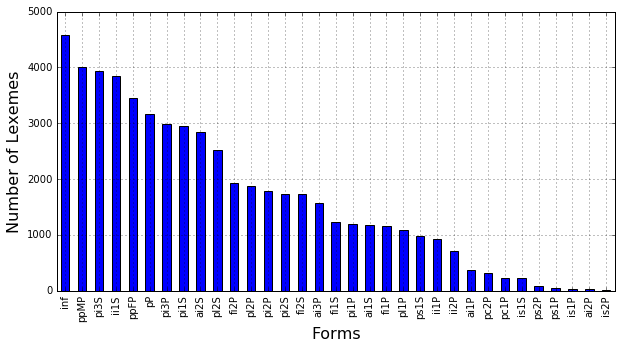

In [368]:
freqCasesSampleTirage=sampleTirage[sampleTirage["tir1"]!=0].groupby("case")[["lexeme"]].count().sort_values("lexeme",ascending=False)
ax=freqCasesSampleTirage.plot(kind="bar",legend=False,grid=True,figsize=(10,5))
ax.set(xlim=(-0.5,32.5),ylim=(0,5000))
ax.set_xlabel("Forms",fontsize=16)
ax.set_ylabel("Number of Lexemes",fontsize=16)

In [439]:
coFormes=paradigmes.copy()
coFormes["nbCoformes"]=coFormes.notnull().sum(axis=1)-1
singletonLexemes=coFormes[coFormes["nbCoformes"]==1]["lexeme"].tolist()
print (coFormes["nbCoformes"].sum(),len(singletonLexemes))

54657 493


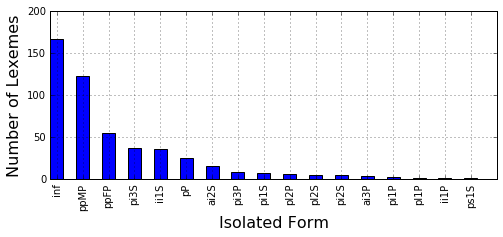

In [440]:
freqCaseSingleton=sampleTirage[(sampleTirage["tir1"]!=0) & (sampleTirage["lexeme"].isin(singletonLexemes))][["case","morphome"]].groupby("case").count()
ax=freqCaseSingleton.sort_values("morphome",ascending=False).plot(kind="bar",legend=False,grid=True,figsize=(8,3))
ax.set(xlim=(-0.25,17),ylim=(0,200))
ax.set_xlabel("Isolated Form",fontsize=16)
ax.set_ylabel("Number of Lexemes",fontsize=16)

In [395]:
sampleTirage[(sampleTirage["tir1"]!=0)]["tir1"].sum()

20000000